In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Keras functional API는 Sequential API보다 더 유연한 모델을 생성하는 방법이다. 

Consider the following model:   

(input: 784-dimensional vectors)   
       ↧   
[Dense (64 units, relu activation)]   
       ↧   
[Dense (64 units, relu activation)]   
       ↧   
[Dense (10 units, softmax activation)]   
       ↧   
(output: logits of a probability distribution over 10 classes)

In [2]:
input = keras.Input(shape=(784,))
print(input.shape, input.dtype)

(None, 784) <dtype: 'float32'>


In [3]:
dense = layers.Dense(64, activation='relu')
x = dense(input)

In [4]:
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(10)(x)

In [5]:
model = keras.Model(inputs=input, outputs=output, name='model')

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


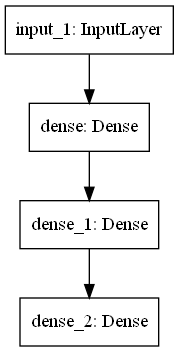

In [13]:
keras.utils.plot_model(model, './resource/model.png')

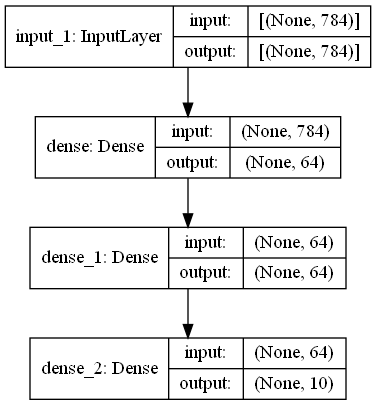

In [14]:
keras.utils.plot_model(model, './resource/model2.png', show_shapes=True)

## 훈련, 평가, 예측


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

In [12]:
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_score = model.evaluate(x_test, y_test, verbose=2)
print('test loss', test_score[0], 'test accuracy', test_score[1])

Epoch 1/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1264 - accuracy: 0.9617 - val_loss: 0.1232 - val_accuracy: 0.9628
Epoch 2/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1003 - accuracy: 0.9696 - val_loss: 0.1124 - val_accuracy: 0.9678
313/313 - 0s - loss: 0.1158 - accuracy: 0.9654
test loss 0.11577774584293365 test accuracy 0.965399980545044


In [15]:
model.save('./model/model.h5')
model = keras.models.load_model('./model/model.h5')

## 돌일한 layer 그래프를 사용해 여러 모델 정의
기능적 API에서 모델은 계층 그래프에서 입력 및 출력을 지정하여 생성된다. 즉, 레이어의 단일 그래프를 사용하여 여러 모델을 생성할 수 있다. 

아래는 동일한 레이어 스택을 사용해 두 모델, an encoder model that turns image inputs into 16-dimensional vectors, and an end-to-end autoencoder model for training.

In [ ]:
input = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(input, encoder_output, name='encoder')
encoder.summary()


x = layers.Reshape((4,4,1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

autoencoder = keras.Model(input, decoder_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

### UpSampling2D
```python
tf.keras.layers.UpSampling2D(
    size=(2, 2), data_format=None, interpolation="nearest", **kwargs
)
```

- size: 2개의 정수로 구성된 튜플, 행과 열에 대한 업샘플링 요인이다. 
- data_format: channels_last(default) or channel_first.   
- interpolation: nearest or bilinear.

In [22]:
input_shape = (2,2,1,3)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
x

array([[[[ 0,  1,  2]],

        [[ 3,  4,  5]]],


       [[[ 6,  7,  8]],

        [[ 9, 10, 11]]]])

In [23]:
y = tf.keras.layers.UpSampling2D(size=(1,2))(x)
y

<tf.Tensor: shape=(2, 2, 2, 3), dtype=int32, numpy=
array([[[[ 0,  1,  2],
         [ 0,  1,  2]],

        [[ 3,  4,  5],
         [ 3,  4,  5]]],


       [[[ 6,  7,  8],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [ 9, 10, 11]]]])>

### Conv2DTranspose
new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] +
output_padding[0])
 
new_cols = ((cols - 1) * strides[1] + kernel_size[1] - 2 * padding[1] +
output_padding[1])

## 모든 모델은 호출가능하다
모델을 입룍이나 다른 계층의 출력에서 호출해 모든 모델을 계층처럼 취급할 수 있다. 

In [26]:
encoder_input = keras.Input(shape=(28,28,1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()


decoder_input = keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4,4,1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 16)                0   

In [27]:
autoencoder_input = keras.Input(shape=(28,28,1),name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                18672     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         9569      
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________
